In [1]:
import sys,os,signal

import numpy as np
import musicnet

import torch
from torch.autograd import Variable
from torch.nn.functional import conv1d, mse_loss

from scipy import fft, fftpack
from time import time

import matplotlib.pyplot as plt
from IPython.display import Audio

from sklearn.metrics import average_precision_score

root = './'

%matplotlib inline

In [2]:
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='2'

def worker_init(args):
    signal.signal(signal.SIGINT, signal.SIG_IGN) # ignore signals so parent can handle them
    np.random.seed(os.getpid() ^ int(time())) # approximately random seed for workers

batch_size = 100
kwargs = {'num_workers': 4, 'pin_memory': True, 'worker_init_fn': worker_init}

m = 128
k = 100 # number of frequency bins?
d = 4096 # size of windows?
window = 16384 # total number of audio samples?
stride = 512
regions = 1 + (window - d)//stride # number of output after sliding the window through x

In [3]:
train_set = musicnet.MusicNet(root=root, train=True, download=True, window=window)#, pitch_shift=5, jitter=.1)
test_set = musicnet.MusicNet(root=root, train=False, window=window, epoch_size=50000)

In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,**kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,**kwargs)

In [5]:
def create_filters(d,k,low=50,high=6000):
    x = np.linspace(0, 2*np.pi, d, endpoint=False)
    wsin = np.empty((k,1,d), dtype=np.float32)
    wcos = np.empty((k,1,d), dtype=np.float32)
    start_freq = low
    end_freq = high
    num_cycles = start_freq*d/44000.
    scaling_ind = np.log(end_freq/start_freq)/k
    window_mask = 1.0-1.0*np.cos(x)
    for ind in range(k):
        wsin[ind,0,:] = window_mask*np.sin(np.exp(ind*scaling_ind)*num_cycles*x)
        wcos[ind,0,:] = window_mask*np.cos(np.exp(ind*scaling_ind)*num_cycles*x)
    
    return wsin,wcos

In [11]:
train_set.

TypeError: access() missing 2 required positional arguments: 'rec_id' and 's'

In [235]:
np.save("waveform_x.np", x)

In [224]:
wsin, wcos = create_filters(d,k)

In [225]:
wsin_var = Variable(torch.from_numpy(wsin).cuda(), requires_grad=False)
wcos_var = Variable(torch.from_numpy(wcos).cuda(),requires_grad=False)

In [226]:
def init_weights():
    wscale = 0.
    beta = Variable(wscale*torch.rand([regions*k,m]).cuda(), requires_grad=True)
    betaavg = Variable(beta.data.clone(), requires_grad=False)
    
    return (beta,), (betaavg)

In [227]:
zx = conv1d(x[:,None,:], wsin_var, stride=stride).pow(2)+conv1d(x[:,None,:], wcos_var, stride=stride).pow(2)

In [228]:
Xs = zx.cpu().numpy()

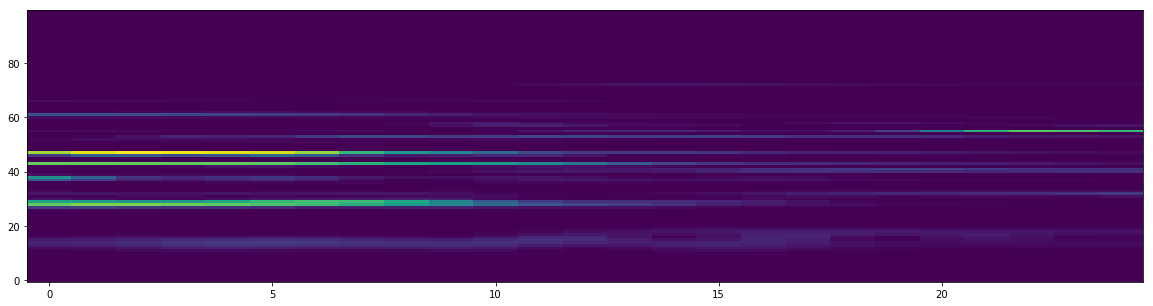

In [229]:
fig = plt.figure(figsize=(20,5))
plt.imshow(Xs[0],aspect='auto')
plt.gca().invert_yaxis()

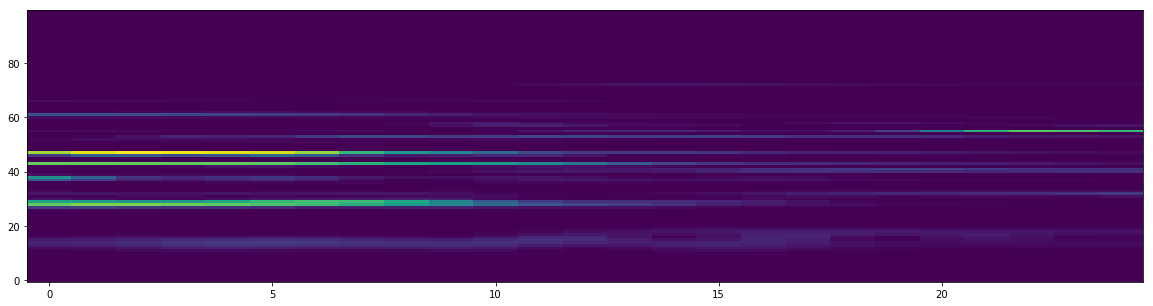

In [230]:
fig = plt.figure(figsize=(20,5))
plt.imshow(Xs[0],aspect='auto')
plt.gca().invert_yaxis()

In [231]:
Xs.shape

(100, 100, 25)

In [182]:
from helperfunction import Waveform

In [183]:
(16384-d)/512

24.0

In [184]:
x[0].shape

torch.Size([16384])

In [185]:
Audio(x[0].cpu().numpy(), rate=441000)

In [201]:
mydata = Waveform(x[0].cpu().numpy(), window_size=d,stride=stride, length=1)

The audio has only 0.372 seconds 
Setting the lenght to the maximum audio lenght


In [187]:
X_list = []
for i in range(25):
    X_list.append(np.abs(fft(x[0].cpu().numpy()[i*stride:i*stride+d])))

In [188]:
X_list = np.array(X_list)

In [189]:
X_list.shape

(25, 4096)

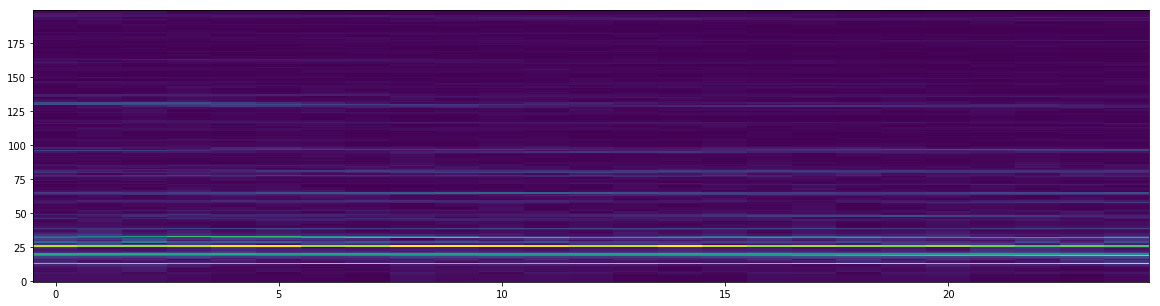

In [215]:
fig = plt.figure(figsize=(20,5))
plt.imshow(X_list.T[:200],aspect='auto')
plt.gca().invert_yaxis()

/opt/conda/lib/python3.6/site-packages/matplotlib/image.py:863: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  self.axes.set_xlim((xmin, xmax), auto=None)


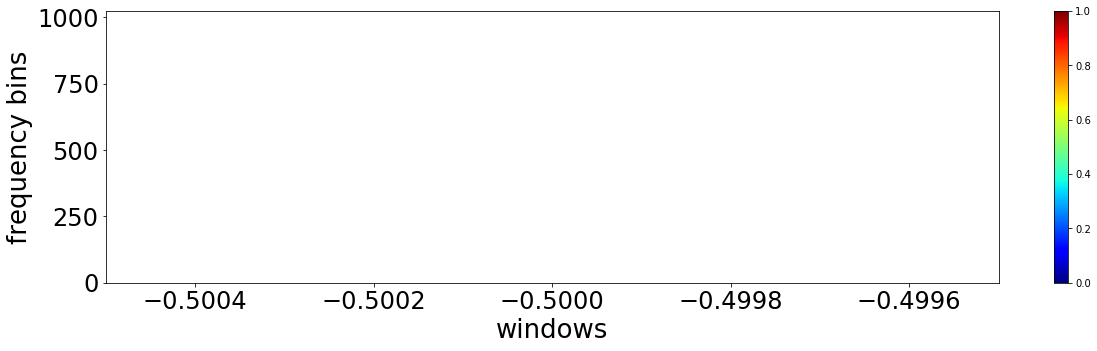

In [128]:
mydata.show_spectrogram()

In [112]:
weights, averages = init_weights()
loss_history = []
avgp_history = []

In [61]:
avg = .9998
optimizer = torch.optim.SGD(weights, lr=0.000001, momentum=.95)

In [62]:
wsin_var.shape


torch.Size([500, 1, 4096])

In [48]:
test = np.array([[[1,2,3],[2,4,6]],[[0,1,2],[1,2,3]]])

In [50]:
torch.from_numpy(test).pow(2)

tensor([[[ 1,  4,  9],
         [ 4, 16, 36]],

        [[ 0,  1,  4],
         [ 1,  4,  9]]])

In [27]:
conv1d(x[:,None,:], wsin_var, stride=stride).pow(2)

tensor([[[4.9668e-03, 9.9762e-02, 5.0565e-02,  ..., 1.1420e-03,
          8.2861e-03, 8.4416e-04],
         [2.1860e-04, 1.0638e-01, 5.3107e-02,  ..., 1.9348e-03,
          8.8768e-03, 2.9876e-03],
         [3.2643e-03, 1.1442e-01, 4.9915e-02,  ..., 2.9085e-03,
          8.8631e-03, 5.9407e-03],
         ...,
         [4.0590e-08, 4.5221e-07, 1.1817e-07,  ..., 6.3707e-08,
          3.0142e-09, 8.9135e-08],
         [1.5716e-08, 3.5709e-07, 6.0157e-07,  ..., 3.8409e-07,
          1.0864e-07, 1.1262e-09],
         [1.4111e-06, 9.3481e-09, 5.9963e-07,  ..., 2.2331e-07,
          8.3535e-07, 2.5672e-08]],

        [[5.6930e-03, 5.6551e-04, 1.9538e-05,  ..., 1.8875e-04,
          9.8873e-04, 5.7844e-02],
         [3.3268e-02, 1.9506e-02, 7.5989e-03,  ..., 7.9458e-03,
          6.1888e-03, 2.1300e-02],
         [7.6336e-02, 5.7416e-02, 2.6193e-02,  ..., 3.4205e-02,
          3.2022e-02, 2.0470e-03],
         ...,
         [1.0985e-05, 1.2296e-05, 2.0981e-06,  ..., 4.1255e-05,
          1.516

In [223]:
try:
    with train_set, test_set:
        print("squre loss\tabg prec\ttime\t\tutime")
        for epoch in range(50):
            t = time()
            for i, (x,y) in enumerate(train_loader):
                optimizer.zero_grad()
                
                # making x and y into pytorch dealable format
                x = Variable(x.cuda(), requires_grad=False) 
                y = Variable(y.cuda(), requires_grad=False) 
                break
            break
except KeyboardInterrupt:
    pass

squre loss	abg prec	time		utime
